# CHILI Challenge

### Chemically-Informed Large-scale Inorganic Nano-materials Dataset for Advancing Graph Machine Learning

* New (unpublished) dataset for materials design
* Predict crystal type, from the structure
* $g_\theta(\cdot): G \rightarrow Y$
* Node features: $G_i: (X_i \in \mathbb{R}^{N_i\times F}, A_i \in \{0,1\}^{N_i\times N_i})$
* crystal_type: $Y = [0,1]^{C}$
* Crystal types belong to ['AntiFluorite', 'CadmiumChloride', 'CadmiumIodide', 'CaesiumChloride', 'Fluorite', 'NickelArsenide', 'RheniumTrioxide',
       'RockSalt', 'Rutile', 'Spinel', 'Wurtzite', 'ZincBlende']
  
  ![Crystal Types](crystal_type.png "Target Crystal Types")
  

In [1]:
### Get dataset
from torch_geometric.data import download_url, extract_zip
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from pathlib import Path
import torch
import os
from torch_geometric.seed import seed_everything
from torcheval.metrics import MulticlassF1Score, MulticlassAccuracy
import torch.nn.functional as F
import torch.nn as nn
import pdb
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')
#torch.manual_seed(0)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Download the preprocessd data
* Data is stored on a remote server
* Download it, unzip it!
* This has to be done only once!!!

In [2]:
data_loc = './Data'
if not Path(data_loc).exists():
    Path(data_loc).mkdir()
else:
    print(data_loc, 'exists!')

./Data exists!


In [3]:
save_dir = './Results'
if not Path(save_dir).exists():
    Path(save_dir).mkdir()
else:
    print(save_dir, 'exists!')

./Results exists!


In [4]:
url = 'https://sid.erda.dk/share_redirect/h7plnJoaYR/CHILI-Challenge.zip'
# path = download_url(url,)
dataset_name = 'CHILI-Challenge'

In [5]:
if not Path(data_loc+'/'+dataset_name+'.zip').exists():
    print('Data not locally found. Downloading...')
    path = download_url(url,data_loc)
    print('Extracting data...')
    extract_zip(path, data_loc)
    data_loc += '/'+dataset_name
    print('Done!')
else:
    print('Data found at '+data_loc)
    data_loc += '/'+dataset_name
    print(os.listdir(data_loc))

Data found at ./Data
['valid.pt', 'test.pt', 'train.pt']


## Load the processed data and investigate

In [6]:
train_set = torch.load(data_loc+'/train.pt')
valid_set = torch.load(data_loc+'/valid.pt')
test_set = torch.load(data_loc+'/test.pt')

In [7]:
nTrain = len(train_set)
nValid = len(valid_set)
nTest = len(test_set)
print('nTrain: %d, nValid: %d, nTest: %d'%(nTrain,nValid,nTest))

nTrain: 2544, nValid: 318, nTest: 318


In [8]:
# Visualize the data point 
sample = train_set[2]
print(sample)

Data(
  x=[119, 4],
  edge_index=[2, 340],
  edge_attr=[340],
  y={
    crystal_type='Spinel',
    crystal_type_number=9,
  },
  pos_frac=[119, 3],
  pos_abs=[119, 3],
  id='data_100'
)


In [9]:
print(sample.pos_abs[:,:2].shape)

torch.Size([119, 2])


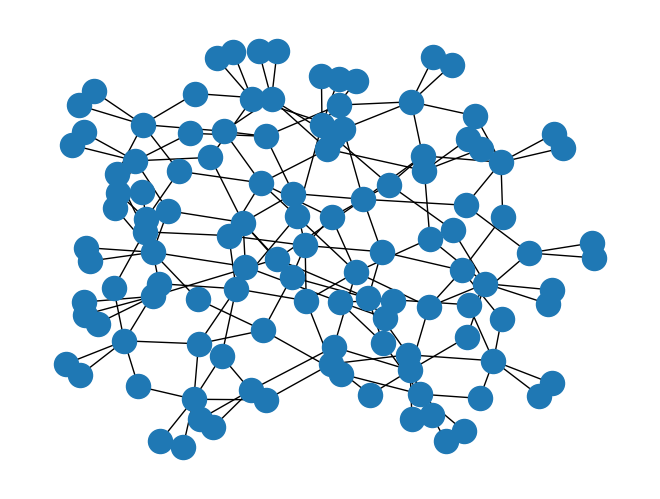

In [10]:
# Basic visualization using networkx
# for more accurate visualization check out https://jp-minerals.org/vesta/en/download.html
import networkx as nx
g = to_networkx(sample, to_undirected=True)
nx.draw(g)

In [11]:
#Class distributions
train_labels = np.array([d.y['crystal_type'] for d in train_set])
crystal_types = np.unique(train_labels)
crystal_type_count = np.array([sum(train_labels==c) for c in crystal_types])
distribution = crystal_type_count/nTrain

<BarContainer object of 12 artists>

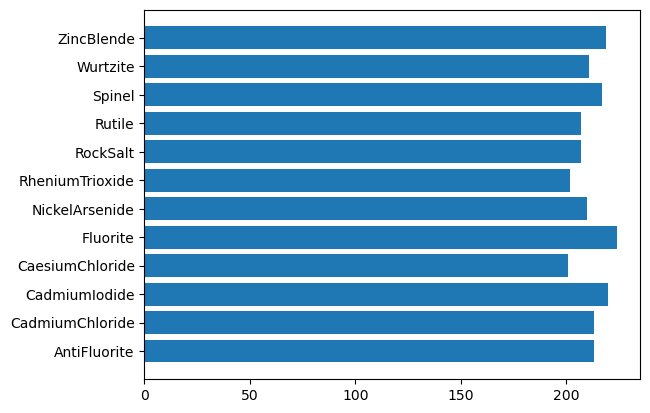

In [12]:
plt.barh(crystal_types,crystal_type_count)

Min. num of nodes: 7
Max. num of nodes: 14793
Mean num of nodes: 2191
Median num of nodes: 1377


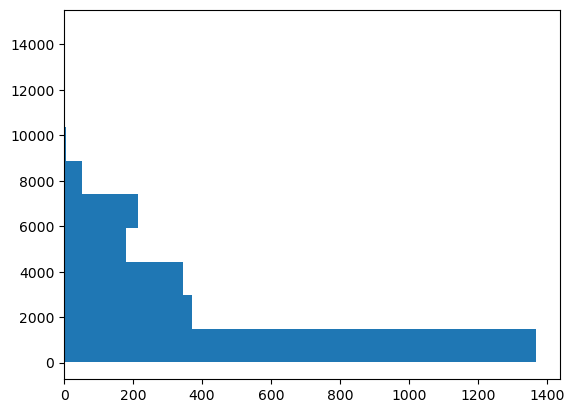

In [13]:
#Num node distributions
train_nodes = [d.x.shape[0] for d in train_set]
plt.hist(train_nodes,orientation='horizontal')
print('Min. num of nodes: %d'%(np.min(train_nodes)))
print('Max. num of nodes: %d'%(np.max(train_nodes)))
print('Mean num of nodes: %d'%(np.mean(train_nodes)))
print('Median num of nodes: %d'%(np.median(train_nodes)))

## Simple basline is to randomly guess the labels
Let us implement a random guessing baseline based on training set distribution

In [14]:
test_set[0]

Data(
  x=[423, 4],
  edge_index=[2, 2792],
  edge_attr=[2792],
  y={
    crystal_type='',
    crystal_type_number=-1,
  },
  pos_frac=[423, 3],
  pos_abs=[423, 3],
  id='data_0'
)

In [15]:
# Random guessing baseline
valid_labels_rand = torch.Tensor(np.random.choice(np.arange(0, 12), size=318, p=distribution))
valid_labels = torch.Tensor(([d.y['crystal_type_number'] for d in valid_set]))

In [16]:
val_acc = sum(valid_labels_rand == valid_labels)/nValid
print(val_acc)

tensor(0.0975)


## UNET implementation

In [17]:
### Make a pytorch-geometric dataloader
B = 16
train_loader = DataLoader(train_set,batch_size=B)
valid_loader = DataLoader(valid_set,batch_size=B)
test_loader = DataLoader(test_set,batch_size=B)

In [18]:
### Load GCN model from pyg
from torch_geometric.nn.models import GCN
from torch_geometric.nn.models import GraphUNet
from torch_geometric.nn import global_mean_pool, Linear, global_add_pool, global_max_pool

In [19]:
n_classes = len(crystal_types)

In [20]:
from typing import Callable, List, Union, Optional, Tuple

#import torch
from torch import Tensor

from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn.resolver import activation_resolver
from torch_geometric.typing import OptTensor, PairTensor
from torch_geometric.utils import (
    add_self_loops,
    remove_self_loops,
    to_torch_csr_tensor,
)
from torch_geometric.utils.repeat import repeat


class GraphUNet(torch.nn.Module):

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        depth: int,
        pool_ratios: Union[float, List[float]] = 0.5,
        sum_res: bool = True,
        act: Union[str, Callable] = 'relu',
        head=None,
        num_layers=2):
        super().__init__()
        assert depth >= 1
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.depth = depth
        self.pool_ratios = repeat(pool_ratios, depth)
        self.act = activation_resolver(act)
        self.sum_res = sum_res

        channels = hidden_channels

        self.down_convs = torch.nn.ModuleList()
        self.pools = torch.nn.ModuleList()
        self.down_convs.append(GCNConv(in_channels, channels, improved=True))
        for i in range(depth):
            self.pools.append(TopKPooling(channels, self.pool_ratios[i]))
            self.down_convs.append(GCNConv(channels, channels, improved=True))

        in_channels = channels if sum_res else 2 * channels

        self.up_convs = torch.nn.ModuleList()
        for i in range(depth - 1):
            self.up_convs.append(GCNConv(in_channels, channels, improved=True))
        self.up_convs.append(GCNConv(in_channels, out_channels, improved=True))
        
        self.gcn1 = GCN(12, hidden_channels=32,\
                         out_channels=32,num_layers=num_layers)
        self.gcn2 = GCN(32, hidden_channels=32, \
                         out_channels=32,num_layers=num_layers)
        self.linear1 = nn.Linear(3*hidden_channels,hidden_channels) # assuming three types of pooling
        self.linear2 = nn.Linear(hidden_channels,out_channels) # assuming three types of pooling

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        for conv in self.down_convs:
            conv.reset_parameters()
        for pool in self.pools:
            pool.reset_parameters()
        for conv in self.up_convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, batch: OptTensor = None) -> Tensor:
        original_batch = batch.clone()
        batch_index = batch.clone()
        if batch is None: #If no batch index is defined everything is in batch #0
            batch = edge_index.new_zeros(x.size(0))
            
        edge_weight = x.new_ones(edge_index.size(1))

        x = self.down_convs[0](x, edge_index, edge_weight)
        x = self.act(x)

        xs = [x]
        edge_indices = [edge_index]
        edge_weights = [edge_weight]
        perms = []
        
        #Coarsening/Pooling part
        for i in range(1, self.depth + 1):
            
            #Sample some important node to make a new graph for feature encoding
            #This is explained (not really) in the paper
            edge_index, edge_weight = self.augment_adj(edge_index, edge_weight, x.size(0))
            
            x, edge_index, edge_weight, batch, perm, _ = self.pools[i - 1](x, edge_index, edge_weight, batch)

            x = self.down_convs[i](x, edge_index, edge_weight)
            x = self.act(x)

            if i < self.depth:
                xs += [x]
                edge_indices += [edge_index]
                edge_weights += [edge_weight]
            perms += [perm]
            
        #Upsampling part
        for i in range(self.depth):
            j = self.depth - 1 - i

            res = xs[j]
            edge_index = edge_indices[j]
            edge_weight = edge_weights[j]
            perm = perms[j]

            up = torch.zeros_like(res)
            up[perm] = x
            x = res + up if self.sum_res else torch.cat((res, up), dim=-1) #stack

            x = self.up_convs[i](x, edge_index, edge_weight)
            x = self.act(x) if i < self.depth - 1 else x
            
            
        #Predictive head
        
        x = self.gcn1(x, edge_index=edge_index)
        x = torch.relu(x)

        x = self.gcn2(x, edge_index=edge_index)
        x = torch.relu(x)
        
        x = torch.cat((global_mean_pool(x, batch_index), \
                     global_add_pool(x, batch_index), \
                     global_max_pool(x, batch_index)), dim=1)
        
        # pdb.set_trace()
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        
        
        return x

    def augment_adj(self, edge_index: Tensor, edge_weight: Tensor, num_nodes: int) -> PairTensor:
        #Graph augmentation for high-level feature encoding
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                 num_nodes=num_nodes)
        adj = to_torch_csr_tensor(edge_index, edge_weight,
                                  size=(num_nodes, num_nodes))
        adj = (adj @ adj).to_sparse_coo()
        edge_index, edge_weight = adj.indices(), adj.values()
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        return edge_index, edge_weight

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.hidden_channels}, {self.out_channels}, '
                f'depth={self.depth}, pool_ratios={self.pool_ratios})')

In [21]:
num_epochs = 1000
lr = 1e-3

In [22]:
model = GraphUNet(in_channels=7,hidden_channels=32,depth=2,out_channels=12, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [23]:
max_patience = 50
patience = 0
for epoch in range(num_epochs):
    model.train()
    total_loss=0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(x=torch.cat((data.x, data.pos_abs),dim=1),\
                    edge_index=data.edge_index,\
                   batch=data.batch)
        target = torch.Tensor(data.y['crystal_type_number']).to(device).long()
        #print(out.shape)
        #print(target.shape)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss =  total_loss/len(train_loader)

    model.eval()
    error = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        MC_Acc = MulticlassAccuracy(num_classes=n_classes)
        for data in valid_loader:
            data = data.to(device)
            out = model(x=torch.cat((data.x, data.pos_abs),dim=1),\
                        edge_index=data.edge_index,
                       batch=data.batch)
            _, predicted = torch.max(out.data,1)
            target = torch.Tensor(data.y['crystal_type_number']).to(device).long()
            MC_Acc.update(predicted,target)

        val_error = torch.tensor(0)
        val_acc = MC_Acc.compute()

        # Save model if validation accuracy is improved
        if epoch == 0:
            best_val_acc = val_acc
            conv_epoch = epoch+1
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                },
                f"{save_dir}/best_big_batch.pt"
                )
        elif val_acc > best_val_acc:
            patience = 0
            
            torch.save({'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),},
                f"{save_dir}/best_big_batch.pt")
            best_val_acc = val_acc
            conv_epoch = epoch+1
        else:
            patience += 1
        if patience == max_patience:
            print('Stopping trainng as max. patience reached. \n Best model at %d'%conv_epoch)
            break

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, \
    Val Acc-score: {val_acc:.4f}', flush=True)    

100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 14.51it/s]


Epoch: 1/1000, Train Loss: 93.8867,     Val Acc-score: 0.1321


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.95it/s]


Epoch: 2/1000, Train Loss: 7.5213,     Val Acc-score: 0.1195


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 3/1000, Train Loss: 4.5848,     Val Acc-score: 0.1258


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 24.15it/s]


Epoch: 4/1000, Train Loss: 3.6609,     Val Acc-score: 0.1352


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.86it/s]


Epoch: 5/1000, Train Loss: 2.9706,     Val Acc-score: 0.1006


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 6/1000, Train Loss: 3.0946,     Val Acc-score: 0.1478


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.67it/s]


Epoch: 7/1000, Train Loss: 2.6092,     Val Acc-score: 0.1698


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.94it/s]


Epoch: 8/1000, Train Loss: 2.5272,     Val Acc-score: 0.1635


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.68it/s]


Epoch: 9/1000, Train Loss: 2.4915,     Val Acc-score: 0.1604


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 10/1000, Train Loss: 2.4674,     Val Acc-score: 0.1572


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.97it/s]


Epoch: 11/1000, Train Loss: 2.4630,     Val Acc-score: 0.1824


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 17.84it/s]


Epoch: 12/1000, Train Loss: 2.4464,     Val Acc-score: 0.2107


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 24.55it/s]


Epoch: 13/1000, Train Loss: 2.3942,     Val Acc-score: 0.2327


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 24.59it/s]


Epoch: 14/1000, Train Loss: 2.4844,     Val Acc-score: 0.1792


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 15/1000, Train Loss: 2.7508,     Val Acc-score: 0.1258


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.02it/s]


Epoch: 16/1000, Train Loss: 2.4613,     Val Acc-score: 0.1698


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 17.17it/s]


Epoch: 17/1000, Train Loss: 2.3944,     Val Acc-score: 0.1730


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.22it/s]


Epoch: 18/1000, Train Loss: 2.3553,     Val Acc-score: 0.2170


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.97it/s]


Epoch: 19/1000, Train Loss: 2.3913,     Val Acc-score: 0.1981


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.67it/s]


Epoch: 20/1000, Train Loss: 2.3694,     Val Acc-score: 0.2107


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.85it/s]


Epoch: 21/1000, Train Loss: 2.4498,     Val Acc-score: 0.1509


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 24.24it/s]


Epoch: 22/1000, Train Loss: 2.4150,     Val Acc-score: 0.1950


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.65it/s]


Epoch: 23/1000, Train Loss: 2.3412,     Val Acc-score: 0.2013


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.85it/s]


Epoch: 24/1000, Train Loss: 2.3963,     Val Acc-score: 0.1195


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 16.81it/s]


Epoch: 25/1000, Train Loss: 2.6035,     Val Acc-score: 0.1415


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.59it/s]


Epoch: 26/1000, Train Loss: 2.4549,     Val Acc-score: 0.1038


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.59it/s]


Epoch: 27/1000, Train Loss: 2.4039,     Val Acc-score: 0.1730


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.83it/s]


Epoch: 28/1000, Train Loss: 2.4148,     Val Acc-score: 0.1006


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.97it/s]


Epoch: 29/1000, Train Loss: 2.3862,     Val Acc-score: 0.1918


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 19.89it/s]


Epoch: 30/1000, Train Loss: 2.3689,     Val Acc-score: 0.2044


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.97it/s]


Epoch: 31/1000, Train Loss: 2.3499,     Val Acc-score: 0.2075


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 16.35it/s]


Epoch: 32/1000, Train Loss: 2.3413,     Val Acc-score: 0.1855


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.59it/s]


Epoch: 33/1000, Train Loss: 2.3568,     Val Acc-score: 0.1887


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.98it/s]


Epoch: 34/1000, Train Loss: 2.2679,     Val Acc-score: 0.1981


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.31it/s]


Epoch: 35/1000, Train Loss: 2.3322,     Val Acc-score: 0.1572


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.58it/s]


Epoch: 36/1000, Train Loss: 2.4366,     Val Acc-score: 0.1950


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.42it/s]


Epoch: 37/1000, Train Loss: 2.3285,     Val Acc-score: 0.1824


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.82it/s]


Epoch: 38/1000, Train Loss: 2.3094,     Val Acc-score: 0.2044


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.82it/s]


Epoch: 39/1000, Train Loss: 2.3396,     Val Acc-score: 0.1604


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.64it/s]


Epoch: 40/1000, Train Loss: 2.2564,     Val Acc-score: 0.1887


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.07it/s]


Epoch: 41/1000, Train Loss: 2.2361,     Val Acc-score: 0.2044


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.69it/s]


Epoch: 42/1000, Train Loss: 2.2494,     Val Acc-score: 0.1761


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.28it/s]


Epoch: 43/1000, Train Loss: 2.1717,     Val Acc-score: 0.2233


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.34it/s]


Epoch: 44/1000, Train Loss: 2.1101,     Val Acc-score: 0.2044


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.40it/s]


Epoch: 45/1000, Train Loss: 2.1769,     Val Acc-score: 0.2044


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.32it/s]


Epoch: 46/1000, Train Loss: 2.0872,     Val Acc-score: 0.2170


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.83it/s]


Epoch: 47/1000, Train Loss: 2.0594,     Val Acc-score: 0.2044


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.51it/s]


Epoch: 48/1000, Train Loss: 2.2349,     Val Acc-score: 0.1038


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.05it/s]


Epoch: 49/1000, Train Loss: 2.1799,     Val Acc-score: 0.1887


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.89it/s]


Epoch: 50/1000, Train Loss: 2.0669,     Val Acc-score: 0.2013


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.28it/s]


Epoch: 51/1000, Train Loss: 2.0678,     Val Acc-score: 0.2358


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.97it/s]


Epoch: 52/1000, Train Loss: 2.0329,     Val Acc-score: 0.2170


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.96it/s]


Epoch: 53/1000, Train Loss: 1.9587,     Val Acc-score: 0.2233


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.65it/s]


Epoch: 54/1000, Train Loss: 1.9711,     Val Acc-score: 0.2421


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.52it/s]


Epoch: 55/1000, Train Loss: 1.9262,     Val Acc-score: 0.2013


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.50it/s]


Epoch: 56/1000, Train Loss: 1.9325,     Val Acc-score: 0.2673


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.39it/s]


Epoch: 57/1000, Train Loss: 1.9110,     Val Acc-score: 0.3113


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.38it/s]


Epoch: 58/1000, Train Loss: 1.8334,     Val Acc-score: 0.3333


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.40it/s]


Epoch: 59/1000, Train Loss: 1.8243,     Val Acc-score: 0.3208


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.43it/s]


Epoch: 60/1000, Train Loss: 1.8211,     Val Acc-score: 0.2736


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.15it/s]


Epoch: 61/1000, Train Loss: 1.7871,     Val Acc-score: 0.2893


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.18it/s]


Epoch: 62/1000, Train Loss: 1.7520,     Val Acc-score: 0.3459


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.47it/s]


Epoch: 63/1000, Train Loss: 1.7189,     Val Acc-score: 0.2673


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.42it/s]


Epoch: 64/1000, Train Loss: 1.6999,     Val Acc-score: 0.3585


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 65/1000, Train Loss: 1.6510,     Val Acc-score: 0.3648


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.80it/s]


Epoch: 66/1000, Train Loss: 1.6661,     Val Acc-score: 0.3176


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.23it/s]


Epoch: 67/1000, Train Loss: 1.6293,     Val Acc-score: 0.3522


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.30it/s]


Epoch: 68/1000, Train Loss: 1.5904,     Val Acc-score: 0.3711


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 19.93it/s]


Epoch: 69/1000, Train Loss: 1.5676,     Val Acc-score: 0.3868


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.42it/s]


Epoch: 70/1000, Train Loss: 1.5319,     Val Acc-score: 0.4119


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 71/1000, Train Loss: 1.4781,     Val Acc-score: 0.4434


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.25it/s]


Epoch: 72/1000, Train Loss: 1.4495,     Val Acc-score: 0.3711


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.16it/s]


Epoch: 73/1000, Train Loss: 1.4599,     Val Acc-score: 0.3805


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.35it/s]


Epoch: 74/1000, Train Loss: 1.4306,     Val Acc-score: 0.3711


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 75/1000, Train Loss: 1.4543,     Val Acc-score: 0.4025


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.49it/s]


Epoch: 76/1000, Train Loss: 1.4084,     Val Acc-score: 0.4025


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.25it/s]


Epoch: 77/1000, Train Loss: 1.3760,     Val Acc-score: 0.4843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.93it/s]


Epoch: 78/1000, Train Loss: 1.3422,     Val Acc-score: 0.3994


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.78it/s]


Epoch: 79/1000, Train Loss: 1.3203,     Val Acc-score: 0.4623


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.32it/s]


Epoch: 80/1000, Train Loss: 1.2973,     Val Acc-score: 0.4277


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.21it/s]


Epoch: 81/1000, Train Loss: 1.2930,     Val Acc-score: 0.4623


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.02it/s]


Epoch: 82/1000, Train Loss: 1.2303,     Val Acc-score: 0.5189


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.39it/s]


Epoch: 83/1000, Train Loss: 1.1823,     Val Acc-score: 0.4906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.80it/s]


Epoch: 84/1000, Train Loss: 1.1748,     Val Acc-score: 0.5283


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.01it/s]


Epoch: 85/1000, Train Loss: 1.1766,     Val Acc-score: 0.5157


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.23it/s]


Epoch: 86/1000, Train Loss: 1.2321,     Val Acc-score: 0.4937


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.61it/s]


Epoch: 87/1000, Train Loss: 1.1809,     Val Acc-score: 0.5440


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.35it/s]


Epoch: 88/1000, Train Loss: 1.2568,     Val Acc-score: 0.4528


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.54it/s]


Epoch: 89/1000, Train Loss: 1.1298,     Val Acc-score: 0.4560


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 90/1000, Train Loss: 1.1368,     Val Acc-score: 0.5189


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.14it/s]


Epoch: 91/1000, Train Loss: 1.0606,     Val Acc-score: 0.5220


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.05it/s]


Epoch: 92/1000, Train Loss: 1.0705,     Val Acc-score: 0.4811


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.00it/s]


Epoch: 93/1000, Train Loss: 1.0436,     Val Acc-score: 0.5220


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.37it/s]


Epoch: 94/1000, Train Loss: 1.0548,     Val Acc-score: 0.5629


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.34it/s]


Epoch: 95/1000, Train Loss: 1.0484,     Val Acc-score: 0.5943


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.99it/s]


Epoch: 96/1000, Train Loss: 1.0145,     Val Acc-score: 0.5912


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 97/1000, Train Loss: 0.9423,     Val Acc-score: 0.5314


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.03it/s]


Epoch: 98/1000, Train Loss: 0.9382,     Val Acc-score: 0.5912


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.36it/s]


Epoch: 99/1000, Train Loss: 0.9027,     Val Acc-score: 0.5597


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.15it/s]


Epoch: 100/1000, Train Loss: 0.9052,     Val Acc-score: 0.5660


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.95it/s]


Epoch: 101/1000, Train Loss: 0.9424,     Val Acc-score: 0.6321


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.77it/s]


Epoch: 102/1000, Train Loss: 0.9175,     Val Acc-score: 0.5252


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.12it/s]


Epoch: 103/1000, Train Loss: 0.9411,     Val Acc-score: 0.6132


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 104/1000, Train Loss: 0.8799,     Val Acc-score: 0.6006


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.87it/s]


Epoch: 105/1000, Train Loss: 0.8723,     Val Acc-score: 0.5881


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.08it/s]


Epoch: 106/1000, Train Loss: 0.9450,     Val Acc-score: 0.6069


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.17it/s]


Epoch: 107/1000, Train Loss: 0.8118,     Val Acc-score: 0.6006


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 108/1000, Train Loss: 0.8642,     Val Acc-score: 0.6321


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.87it/s]


Epoch: 109/1000, Train Loss: 0.8136,     Val Acc-score: 0.5535


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.30it/s]


Epoch: 110/1000, Train Loss: 0.8380,     Val Acc-score: 0.6195


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.00it/s]


Epoch: 111/1000, Train Loss: 0.7698,     Val Acc-score: 0.6006


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.22it/s]


Epoch: 112/1000, Train Loss: 0.8184,     Val Acc-score: 0.6101


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 18.81it/s]


Epoch: 113/1000, Train Loss: 0.7522,     Val Acc-score: 0.5755


100%|█████████████████████████████████████████| 159/159 [00:11<00:00, 13.77it/s]


Epoch: 114/1000, Train Loss: 0.7693,     Val Acc-score: 0.5629


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.64it/s]


Epoch: 115/1000, Train Loss: 0.7212,     Val Acc-score: 0.5881


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.08it/s]


Epoch: 116/1000, Train Loss: 0.7116,     Val Acc-score: 0.6352


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.98it/s]


Epoch: 117/1000, Train Loss: 0.7362,     Val Acc-score: 0.6289


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.48it/s]


Epoch: 118/1000, Train Loss: 0.7529,     Val Acc-score: 0.6635


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 119/1000, Train Loss: 0.9408,     Val Acc-score: 0.6384


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 17.76it/s]


Epoch: 120/1000, Train Loss: 0.7251,     Val Acc-score: 0.6447


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.10it/s]


Epoch: 121/1000, Train Loss: 0.6591,     Val Acc-score: 0.6824


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.59it/s]


Epoch: 122/1000, Train Loss: 0.7250,     Val Acc-score: 0.6792


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.94it/s]


Epoch: 123/1000, Train Loss: 0.6878,     Val Acc-score: 0.6918


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.00it/s]


Epoch: 124/1000, Train Loss: 0.6376,     Val Acc-score: 0.6478


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.17it/s]


Epoch: 125/1000, Train Loss: 0.6506,     Val Acc-score: 0.6509


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.88it/s]


Epoch: 126/1000, Train Loss: 0.6752,     Val Acc-score: 0.6667


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.90it/s]


Epoch: 127/1000, Train Loss: 0.6661,     Val Acc-score: 0.6950


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.08it/s]


Epoch: 128/1000, Train Loss: 0.6571,     Val Acc-score: 0.7075


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 129/1000, Train Loss: 0.6524,     Val Acc-score: 0.7013


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.92it/s]


Epoch: 130/1000, Train Loss: 0.6211,     Val Acc-score: 0.7107


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.93it/s]


Epoch: 131/1000, Train Loss: 0.6993,     Val Acc-score: 0.6698


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 132/1000, Train Loss: 0.6499,     Val Acc-score: 0.7327


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 133/1000, Train Loss: 0.6891,     Val Acc-score: 0.6981


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.30it/s]


Epoch: 134/1000, Train Loss: 0.6503,     Val Acc-score: 0.6981


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.97it/s]


Epoch: 135/1000, Train Loss: 0.5637,     Val Acc-score: 0.7421


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.82it/s]


Epoch: 136/1000, Train Loss: 0.5932,     Val Acc-score: 0.7421


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 137/1000, Train Loss: 0.5761,     Val Acc-score: 0.7013


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.90it/s]


Epoch: 138/1000, Train Loss: 0.5507,     Val Acc-score: 0.7704


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.85it/s]


Epoch: 139/1000, Train Loss: 0.6092,     Val Acc-score: 0.8019


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.26it/s]


Epoch: 140/1000, Train Loss: 0.6453,     Val Acc-score: 0.7453


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 141/1000, Train Loss: 0.5114,     Val Acc-score: 0.7673


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.44it/s]


Epoch: 142/1000, Train Loss: 0.5390,     Val Acc-score: 0.7767


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.34it/s]


Epoch: 143/1000, Train Loss: 0.5712,     Val Acc-score: 0.6855


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.37it/s]


Epoch: 144/1000, Train Loss: 0.6476,     Val Acc-score: 0.7987


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.38it/s]


Epoch: 145/1000, Train Loss: 0.5225,     Val Acc-score: 0.8019


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.30it/s]


Epoch: 146/1000, Train Loss: 0.5481,     Val Acc-score: 0.7610


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.33it/s]


Epoch: 147/1000, Train Loss: 0.6452,     Val Acc-score: 0.7484


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.20it/s]


Epoch: 148/1000, Train Loss: 0.5402,     Val Acc-score: 0.7925


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.53it/s]


Epoch: 149/1000, Train Loss: 0.6173,     Val Acc-score: 0.8491


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.90it/s]


Epoch: 150/1000, Train Loss: 0.5191,     Val Acc-score: 0.8679


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.73it/s]


Epoch: 151/1000, Train Loss: 0.4923,     Val Acc-score: 0.8208


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.72it/s]


Epoch: 152/1000, Train Loss: 0.4549,     Val Acc-score: 0.8239


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.24it/s]


Epoch: 153/1000, Train Loss: 0.4540,     Val Acc-score: 0.8522


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.28it/s]


Epoch: 154/1000, Train Loss: 0.4566,     Val Acc-score: 0.8270


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 155/1000, Train Loss: 0.5048,     Val Acc-score: 0.7862


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.72it/s]


Epoch: 156/1000, Train Loss: 0.4257,     Val Acc-score: 0.8082


100%|█████████████████████████████████████████| 159/159 [00:11<00:00, 14.36it/s]


Epoch: 157/1000, Train Loss: 0.4336,     Val Acc-score: 0.7830


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 158/1000, Train Loss: 0.4100,     Val Acc-score: 0.8082


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.70it/s]


Epoch: 159/1000, Train Loss: 0.3701,     Val Acc-score: 0.7956


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 160/1000, Train Loss: 0.4524,     Val Acc-score: 0.7610


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.91it/s]


Epoch: 161/1000, Train Loss: 0.4645,     Val Acc-score: 0.8302


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 162/1000, Train Loss: 0.3847,     Val Acc-score: 0.8365


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 163/1000, Train Loss: 0.4615,     Val Acc-score: 0.7138


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.95it/s]


Epoch: 164/1000, Train Loss: 0.4472,     Val Acc-score: 0.8365


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 165/1000, Train Loss: 0.3545,     Val Acc-score: 0.8113


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.17it/s]


Epoch: 166/1000, Train Loss: 0.3918,     Val Acc-score: 0.8050


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.12it/s]


Epoch: 167/1000, Train Loss: 0.3685,     Val Acc-score: 0.8302


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.49it/s]


Epoch: 168/1000, Train Loss: 0.3551,     Val Acc-score: 0.8396


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.80it/s]


Epoch: 169/1000, Train Loss: 0.4558,     Val Acc-score: 0.8522


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 170/1000, Train Loss: 0.4212,     Val Acc-score: 0.8145


100%|█████████████████████████████████████████| 159/159 [00:15<00:00, 10.45it/s]


Epoch: 171/1000, Train Loss: 0.3526,     Val Acc-score: 0.8491


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.01it/s]


Epoch: 172/1000, Train Loss: 0.3113,     Val Acc-score: 0.8648


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.32it/s]


Epoch: 173/1000, Train Loss: 0.3102,     Val Acc-score: 0.8522


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.48it/s]


Epoch: 174/1000, Train Loss: 0.3414,     Val Acc-score: 0.7264


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.70it/s]


Epoch: 175/1000, Train Loss: 0.4268,     Val Acc-score: 0.8365


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.74it/s]


Epoch: 176/1000, Train Loss: 0.3372,     Val Acc-score: 0.8428


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.76it/s]


Epoch: 177/1000, Train Loss: 0.3136,     Val Acc-score: 0.8553


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 16.06it/s]


Epoch: 178/1000, Train Loss: 0.3143,     Val Acc-score: 0.8428


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.70it/s]


Epoch: 179/1000, Train Loss: 0.3162,     Val Acc-score: 0.8145


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.61it/s]


Epoch: 180/1000, Train Loss: 0.3189,     Val Acc-score: 0.8774


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.70it/s]


Epoch: 181/1000, Train Loss: 0.3263,     Val Acc-score: 0.8962


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.96it/s]


Epoch: 182/1000, Train Loss: 0.4375,     Val Acc-score: 0.8899


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.12it/s]


Epoch: 183/1000, Train Loss: 0.3280,     Val Acc-score: 0.8679


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.19it/s]


Epoch: 184/1000, Train Loss: 0.2759,     Val Acc-score: 0.8616


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.66it/s]


Epoch: 185/1000, Train Loss: 0.2773,     Val Acc-score: 0.8585


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 17.29it/s]


Epoch: 186/1000, Train Loss: 0.2699,     Val Acc-score: 0.8805


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.33it/s]


Epoch: 187/1000, Train Loss: 0.2987,     Val Acc-score: 0.8553


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.24it/s]


Epoch: 188/1000, Train Loss: 0.4190,     Val Acc-score: 0.8491


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.15it/s]


Epoch: 189/1000, Train Loss: 0.4038,     Val Acc-score: 0.8648


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.35it/s]


Epoch: 190/1000, Train Loss: 0.2763,     Val Acc-score: 0.8899


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.35it/s]


Epoch: 191/1000, Train Loss: 0.2333,     Val Acc-score: 0.8805


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.70it/s]


Epoch: 192/1000, Train Loss: 0.2318,     Val Acc-score: 0.8836


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.31it/s]


Epoch: 193/1000, Train Loss: 0.2416,     Val Acc-score: 0.9088


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.33it/s]


Epoch: 194/1000, Train Loss: 0.3410,     Val Acc-score: 0.7862


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.15it/s]


Epoch: 195/1000, Train Loss: 0.4280,     Val Acc-score: 0.8679


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.44it/s]


Epoch: 196/1000, Train Loss: 0.2295,     Val Acc-score: 0.8742


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.24it/s]


Epoch: 197/1000, Train Loss: 0.2721,     Val Acc-score: 0.9025


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.28it/s]


Epoch: 198/1000, Train Loss: 0.2973,     Val Acc-score: 0.8742


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.35it/s]


Epoch: 199/1000, Train Loss: 0.2688,     Val Acc-score: 0.9088


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.74it/s]


Epoch: 200/1000, Train Loss: 0.2416,     Val Acc-score: 0.8931


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.77it/s]


Epoch: 201/1000, Train Loss: 0.1959,     Val Acc-score: 0.9214


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.34it/s]


Epoch: 202/1000, Train Loss: 0.2087,     Val Acc-score: 0.8616


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.48it/s]


Epoch: 203/1000, Train Loss: 0.5482,     Val Acc-score: 0.8836


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.01it/s]


Epoch: 204/1000, Train Loss: 0.3040,     Val Acc-score: 0.9057


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.95it/s]


Epoch: 205/1000, Train Loss: 0.2642,     Val Acc-score: 0.9088


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.45it/s]


Epoch: 206/1000, Train Loss: 0.1991,     Val Acc-score: 0.8491


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.27it/s]


Epoch: 207/1000, Train Loss: 0.1993,     Val Acc-score: 0.8931


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.05it/s]


Epoch: 208/1000, Train Loss: 0.1854,     Val Acc-score: 0.9340


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.10it/s]


Epoch: 209/1000, Train Loss: 0.4332,     Val Acc-score: 0.8805


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 210/1000, Train Loss: 0.2240,     Val Acc-score: 0.8742


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.25it/s]


Epoch: 211/1000, Train Loss: 0.1860,     Val Acc-score: 0.8333


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.94it/s]


Epoch: 212/1000, Train Loss: 0.2283,     Val Acc-score: 0.9119


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 18.14it/s]


Epoch: 213/1000, Train Loss: 0.2052,     Val Acc-score: 0.8774


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.33it/s]


Epoch: 214/1000, Train Loss: 0.3478,     Val Acc-score: 0.8994


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.32it/s]


Epoch: 215/1000, Train Loss: 0.2896,     Val Acc-score: 0.8836


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 216/1000, Train Loss: 0.2178,     Val Acc-score: 0.9182


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.19it/s]


Epoch: 217/1000, Train Loss: 0.2402,     Val Acc-score: 0.7673


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.28it/s]


Epoch: 218/1000, Train Loss: 0.2151,     Val Acc-score: 0.8962


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 219/1000, Train Loss: 0.3027,     Val Acc-score: 0.9182


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 220/1000, Train Loss: 0.1687,     Val Acc-score: 0.8962


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.37it/s]


Epoch: 221/1000, Train Loss: 0.1943,     Val Acc-score: 0.8868


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.17it/s]


Epoch: 222/1000, Train Loss: 0.1794,     Val Acc-score: 0.7358


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.15it/s]


Epoch: 223/1000, Train Loss: 0.2535,     Val Acc-score: 0.8899


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.73it/s]


Epoch: 224/1000, Train Loss: 0.1955,     Val Acc-score: 0.8868


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.14it/s]


Epoch: 225/1000, Train Loss: 0.2016,     Val Acc-score: 0.8836


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.57it/s]


Epoch: 226/1000, Train Loss: 0.3007,     Val Acc-score: 0.9088


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.21it/s]


Epoch: 227/1000, Train Loss: 0.2456,     Val Acc-score: 0.9308


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.84it/s]


Epoch: 228/1000, Train Loss: 0.2078,     Val Acc-score: 0.8679


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.94it/s]


Epoch: 229/1000, Train Loss: 0.2148,     Val Acc-score: 0.9371


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.20it/s]


Epoch: 230/1000, Train Loss: 0.1618,     Val Acc-score: 0.9277


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.18it/s]


Epoch: 231/1000, Train Loss: 0.2189,     Val Acc-score: 0.8333


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.80it/s]


Epoch: 232/1000, Train Loss: 0.2111,     Val Acc-score: 0.9245


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.32it/s]


Epoch: 233/1000, Train Loss: 0.2517,     Val Acc-score: 0.9277


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.18it/s]


Epoch: 234/1000, Train Loss: 0.1587,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.98it/s]


Epoch: 235/1000, Train Loss: 0.1535,     Val Acc-score: 0.9245


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.31it/s]


Epoch: 236/1000, Train Loss: 0.1957,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.72it/s]


Epoch: 237/1000, Train Loss: 0.2124,     Val Acc-score: 0.8899


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.95it/s]


Epoch: 238/1000, Train Loss: 0.1325,     Val Acc-score: 0.9403


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.15it/s]


Epoch: 239/1000, Train Loss: 0.1209,     Val Acc-score: 0.9497


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 240/1000, Train Loss: 0.3098,     Val Acc-score: 0.9182


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.80it/s]


Epoch: 241/1000, Train Loss: 0.2331,     Val Acc-score: 0.9277


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.90it/s]


Epoch: 242/1000, Train Loss: 0.1531,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.50it/s]


Epoch: 243/1000, Train Loss: 0.1420,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.53it/s]


Epoch: 244/1000, Train Loss: 0.1315,     Val Acc-score: 0.9245


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.07it/s]


Epoch: 245/1000, Train Loss: 0.1451,     Val Acc-score: 0.9465


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.95it/s]


Epoch: 246/1000, Train Loss: 0.1682,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.50it/s]


Epoch: 247/1000, Train Loss: 0.4305,     Val Acc-score: 0.9277


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 248/1000, Train Loss: 0.1958,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.97it/s]


Epoch: 249/1000, Train Loss: 0.1300,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 17.41it/s]


Epoch: 250/1000, Train Loss: 0.1436,     Val Acc-score: 0.9403


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.08it/s]


Epoch: 251/1000, Train Loss: 0.2241,     Val Acc-score: 0.8836


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.17it/s]


Epoch: 252/1000, Train Loss: 0.1269,     Val Acc-score: 0.9623


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.67it/s]


Epoch: 253/1000, Train Loss: 0.1469,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.45it/s]


Epoch: 254/1000, Train Loss: 0.2390,     Val Acc-score: 0.9371


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.18it/s]


Epoch: 255/1000, Train Loss: 0.1245,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.47it/s]


Epoch: 256/1000, Train Loss: 0.1735,     Val Acc-score: 0.9497


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.23it/s]


Epoch: 257/1000, Train Loss: 0.1496,     Val Acc-score: 0.8994


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.24it/s]


Epoch: 258/1000, Train Loss: 0.1813,     Val Acc-score: 0.9277


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.25it/s]


Epoch: 259/1000, Train Loss: 0.1504,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.94it/s]


Epoch: 260/1000, Train Loss: 0.1000,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.45it/s]


Epoch: 261/1000, Train Loss: 0.1687,     Val Acc-score: 0.9560


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.33it/s]


Epoch: 262/1000, Train Loss: 0.1487,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.30it/s]


Epoch: 263/1000, Train Loss: 0.2395,     Val Acc-score: 0.9497


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.80it/s]


Epoch: 264/1000, Train Loss: 0.1454,     Val Acc-score: 0.9057


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.39it/s]


Epoch: 265/1000, Train Loss: 0.1413,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.89it/s]


Epoch: 266/1000, Train Loss: 0.1248,     Val Acc-score: 0.9088


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.31it/s]


Epoch: 267/1000, Train Loss: 0.1006,     Val Acc-score: 0.9591


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.30it/s]


Epoch: 268/1000, Train Loss: 0.1161,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.04it/s]


Epoch: 269/1000, Train Loss: 0.1102,     Val Acc-score: 0.9371


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.98it/s]


Epoch: 270/1000, Train Loss: 0.1082,     Val Acc-score: 0.8994


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.69it/s]


Epoch: 271/1000, Train Loss: 0.1470,     Val Acc-score: 0.9025


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.30it/s]


Epoch: 272/1000, Train Loss: 0.2122,     Val Acc-score: 0.7799


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.89it/s]


Epoch: 273/1000, Train Loss: 0.1638,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.74it/s]


Epoch: 274/1000, Train Loss: 0.1140,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.38it/s]


Epoch: 275/1000, Train Loss: 0.0717,     Val Acc-score: 0.9591


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.41it/s]


Epoch: 276/1000, Train Loss: 0.0910,     Val Acc-score: 0.9811


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.65it/s]


Epoch: 277/1000, Train Loss: 0.0850,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.31it/s]


Epoch: 278/1000, Train Loss: 0.1452,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.58it/s]


Epoch: 279/1000, Train Loss: 0.2235,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.04it/s]


Epoch: 280/1000, Train Loss: 0.2697,     Val Acc-score: 0.9623


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.02it/s]


Epoch: 281/1000, Train Loss: 0.1049,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.54it/s]


Epoch: 282/1000, Train Loss: 0.0988,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.84it/s]


Epoch: 283/1000, Train Loss: 0.0838,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 14.52it/s]


Epoch: 284/1000, Train Loss: 0.0956,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.22it/s]


Epoch: 285/1000, Train Loss: 0.0770,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.72it/s]


Epoch: 286/1000, Train Loss: 0.0490,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 18.91it/s]


Epoch: 287/1000, Train Loss: 0.0970,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.01it/s]


Epoch: 288/1000, Train Loss: 0.0944,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.19it/s]


Epoch: 289/1000, Train Loss: 0.1924,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.73it/s]


Epoch: 290/1000, Train Loss: 0.0866,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.79it/s]


Epoch: 291/1000, Train Loss: 0.0732,     Val Acc-score: 0.9308


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.22it/s]


Epoch: 292/1000, Train Loss: 0.1917,     Val Acc-score: 0.9497


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 293/1000, Train Loss: 0.1037,     Val Acc-score: 0.9560


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.87it/s]


Epoch: 294/1000, Train Loss: 0.2777,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.04it/s]


Epoch: 295/1000, Train Loss: 0.0701,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 296/1000, Train Loss: 0.0752,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.01it/s]


Epoch: 297/1000, Train Loss: 0.0828,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 16.41it/s]


Epoch: 298/1000, Train Loss: 0.0487,     Val Acc-score: 0.9811


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.08it/s]


Epoch: 299/1000, Train Loss: 0.0451,     Val Acc-score: 0.9623


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.18it/s]


Epoch: 300/1000, Train Loss: 0.1027,     Val Acc-score: 0.9214


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.97it/s]


Epoch: 301/1000, Train Loss: 0.1611,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.56it/s]


Epoch: 302/1000, Train Loss: 0.1920,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 303/1000, Train Loss: 0.1573,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.82it/s]


Epoch: 304/1000, Train Loss: 0.0799,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.99it/s]


Epoch: 305/1000, Train Loss: 0.0674,     Val Acc-score: 0.9623


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 306/1000, Train Loss: 0.1208,     Val Acc-score: 0.8742


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 307/1000, Train Loss: 0.1556,     Val Acc-score: 0.9403


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.65it/s]


Epoch: 308/1000, Train Loss: 0.3418,     Val Acc-score: 0.9403


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.17it/s]


Epoch: 309/1000, Train Loss: 0.1035,     Val Acc-score: 0.9811


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.26it/s]


Epoch: 310/1000, Train Loss: 0.0813,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 311/1000, Train Loss: 0.0689,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.84it/s]


Epoch: 312/1000, Train Loss: 0.0507,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.78it/s]


Epoch: 313/1000, Train Loss: 0.0461,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.10it/s]


Epoch: 314/1000, Train Loss: 0.0770,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.21it/s]


Epoch: 315/1000, Train Loss: 0.0418,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.20it/s]


Epoch: 316/1000, Train Loss: 0.0320,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.39it/s]


Epoch: 317/1000, Train Loss: 0.0471,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.51it/s]


Epoch: 318/1000, Train Loss: 0.0382,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 319/1000, Train Loss: 0.2139,     Val Acc-score: 0.9465


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.55it/s]


Epoch: 320/1000, Train Loss: 0.0748,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.82it/s]


Epoch: 321/1000, Train Loss: 0.0705,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.98it/s]


Epoch: 322/1000, Train Loss: 0.2206,     Val Acc-score: 0.9308


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 323/1000, Train Loss: 0.1216,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 324/1000, Train Loss: 0.0376,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 325/1000, Train Loss: 0.0194,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.92it/s]


Epoch: 326/1000, Train Loss: 0.0164,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.94it/s]


Epoch: 327/1000, Train Loss: 0.0170,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.03it/s]


Epoch: 328/1000, Train Loss: 0.1147,     Val Acc-score: 0.9403


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.04it/s]


Epoch: 329/1000, Train Loss: 0.2406,     Val Acc-score: 0.9497


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.82it/s]


Epoch: 330/1000, Train Loss: 0.0423,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.67it/s]


Epoch: 331/1000, Train Loss: 0.0483,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.61it/s]


Epoch: 332/1000, Train Loss: 0.0433,     Val Acc-score: 0.9560


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.79it/s]


Epoch: 333/1000, Train Loss: 0.1253,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.89it/s]


Epoch: 334/1000, Train Loss: 0.0299,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.05it/s]


Epoch: 335/1000, Train Loss: 0.0174,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.61it/s]


Epoch: 336/1000, Train Loss: 0.0114,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.91it/s]


Epoch: 337/1000, Train Loss: 0.0101,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.92it/s]


Epoch: 338/1000, Train Loss: 0.0104,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.03it/s]


Epoch: 339/1000, Train Loss: 0.0098,     Val Acc-score: 0.9811


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.60it/s]


Epoch: 340/1000, Train Loss: 0.4176,     Val Acc-score: 0.8459


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 341/1000, Train Loss: 0.3579,     Val Acc-score: 0.9025


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.92it/s]


Epoch: 342/1000, Train Loss: 0.1133,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.89it/s]


Epoch: 343/1000, Train Loss: 0.1040,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.07it/s]


Epoch: 344/1000, Train Loss: 0.0471,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.01it/s]


Epoch: 345/1000, Train Loss: 0.0424,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.46it/s]


Epoch: 346/1000, Train Loss: 0.0363,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.68it/s]


Epoch: 347/1000, Train Loss: 0.0391,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.89it/s]


Epoch: 348/1000, Train Loss: 0.0930,     Val Acc-score: 0.8302


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.86it/s]


Epoch: 349/1000, Train Loss: 0.1623,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.61it/s]


Epoch: 350/1000, Train Loss: 0.0524,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.97it/s]


Epoch: 351/1000, Train Loss: 0.0329,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.43it/s]


Epoch: 352/1000, Train Loss: 0.0168,     Val Acc-score: 0.9969


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.94it/s]


Epoch: 353/1000, Train Loss: 0.0166,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.12it/s]


Epoch: 354/1000, Train Loss: 0.0235,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.07it/s]


Epoch: 355/1000, Train Loss: 0.1589,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.15it/s]


Epoch: 356/1000, Train Loss: 0.0444,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.65it/s]


Epoch: 357/1000, Train Loss: 0.0118,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.84it/s]


Epoch: 358/1000, Train Loss: 0.0890,     Val Acc-score: 0.9591


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.29it/s]


Epoch: 359/1000, Train Loss: 0.0983,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.91it/s]


Epoch: 360/1000, Train Loss: 0.1158,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.28it/s]


Epoch: 361/1000, Train Loss: 0.1863,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.65it/s]


Epoch: 362/1000, Train Loss: 0.0263,     Val Acc-score: 0.9937


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.95it/s]


Epoch: 363/1000, Train Loss: 0.0256,     Val Acc-score: 0.9811


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 364/1000, Train Loss: 0.0173,     Val Acc-score: 0.9811


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.06it/s]


Epoch: 365/1000, Train Loss: 0.0121,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.99it/s]


Epoch: 366/1000, Train Loss: 0.1344,     Val Acc-score: 0.9214


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.79it/s]


Epoch: 367/1000, Train Loss: 0.1505,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.54it/s]


Epoch: 368/1000, Train Loss: 0.1081,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 369/1000, Train Loss: 0.0550,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 370/1000, Train Loss: 0.0320,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.89it/s]


Epoch: 371/1000, Train Loss: 0.0384,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.75it/s]


Epoch: 372/1000, Train Loss: 0.0774,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.05it/s]


Epoch: 373/1000, Train Loss: 0.1050,     Val Acc-score: 0.9497


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.34it/s]


Epoch: 374/1000, Train Loss: 0.0316,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.54it/s]


Epoch: 375/1000, Train Loss: 0.0117,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.74it/s]


Epoch: 376/1000, Train Loss: 0.0503,     Val Acc-score: 0.9686


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.10it/s]


Epoch: 377/1000, Train Loss: 0.1247,     Val Acc-score: 0.9371


100%|█████████████████████████████████████████| 159/159 [00:10<00:00, 15.77it/s]


Epoch: 378/1000, Train Loss: 0.2844,     Val Acc-score: 0.9528


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 19.69it/s]


Epoch: 379/1000, Train Loss: 0.1246,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.16it/s]


Epoch: 380/1000, Train Loss: 0.0412,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.59it/s]


Epoch: 381/1000, Train Loss: 0.0190,     Val Acc-score: 0.9906


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.62it/s]


Epoch: 382/1000, Train Loss: 0.2896,     Val Acc-score: 0.9780


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.96it/s]


Epoch: 383/1000, Train Loss: 0.0656,     Val Acc-score: 0.9591


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.38it/s]


Epoch: 384/1000, Train Loss: 0.1181,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.34it/s]


Epoch: 385/1000, Train Loss: 0.0145,     Val Acc-score: 0.9937


100%|█████████████████████████████████████████| 159/159 [00:11<00:00, 14.44it/s]


Epoch: 386/1000, Train Loss: 0.0084,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:09<00:00, 17.23it/s]


Epoch: 387/1000, Train Loss: 0.0089,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.67it/s]


Epoch: 388/1000, Train Loss: 0.0066,     Val Acc-score: 0.9969


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 20.08it/s]


Epoch: 389/1000, Train Loss: 0.0091,     Val Acc-score: 0.9969


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.96it/s]


Epoch: 390/1000, Train Loss: 0.0445,     Val Acc-score: 0.9937


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.02it/s]


Epoch: 391/1000, Train Loss: 0.0608,     Val Acc-score: 0.9654


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 21.98it/s]


Epoch: 392/1000, Train Loss: 0.1273,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:08<00:00, 18.27it/s]


Epoch: 393/1000, Train Loss: 0.0977,     Val Acc-score: 0.9465


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.16it/s]


Epoch: 394/1000, Train Loss: 0.0729,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.12it/s]


Epoch: 395/1000, Train Loss: 0.1060,     Val Acc-score: 0.9748


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.13it/s]


Epoch: 396/1000, Train Loss: 0.0471,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.76it/s]


Epoch: 397/1000, Train Loss: 0.1432,     Val Acc-score: 0.9434


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.11it/s]


Epoch: 398/1000, Train Loss: 0.0838,     Val Acc-score: 0.9717


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 23.09it/s]


Epoch: 399/1000, Train Loss: 0.1046,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:07<00:00, 22.48it/s]


Epoch: 400/1000, Train Loss: 0.0414,     Val Acc-score: 0.9843


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.72it/s]


Epoch: 401/1000, Train Loss: 0.0717,     Val Acc-score: 0.9874


100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.91it/s]


Stopping trainng as max. patience reached. 
 Best model at 352


### Use the final converged model to predict on test set

In [24]:
checkpoint = torch.load(f"{save_dir}/best_big_batch.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

GraphUNet(7, 32, 12, depth=2, pool_ratios=[0.5, 0.5])

In [25]:
# Load the best model and predict on test set
import time 
timestamp = time.strftime("%Y%m%d-%H%M%S")
print(timestamp)

20240202-112221


In [26]:
# Load the best model and predict on test set
import time 
timestamp = time.strftime("%Y%m%d_%H%M%S")

test_id = [d.id for d in test_set]
results = pd.DataFrame(columns=['id','predicted_label'],index=np.arange(nTest))
results.id = test_id

with torch.no_grad():    
    for data in test_loader:
        data = data.to(device)
        out = model(x=torch.cat((data.x, data.pos_abs),dim=1),\
                        edge_index=data.edge_index,
                       batch=data.batch)
        _, predicted = torch.max(out.data,1)
        results.loc[results.id.isin(data.id),'predicted_label'] = predicted.cpu()

results.to_csv(f"{save_dir}/results_"+timestamp+".csv",index=False)
print("Saved results to "+f"{save_dir}/results_"+timestamp+".csv")

Saved results to ./Results/results_20240202_112221.csv
